## GROUP 4
- Lorenza Di Mauro
- Raffaele Sannino
- Maria Raffaella Zampella  

# Monet challenge
This notebook utilizes a **CycleGAN** architecture to add Monet-style to photos. For this tutorial, we will be using the TFRecord dataset.
For more information, check out TensorFlow and Keras CycleGAN documentation pages.

Why we decide to use Cycle Gan ? 

Training a model for image-to-image translation typically requires a large dataset of paired examples. These datasets can be difficult and expensive to prepare, and in some cases impossible, such as photographs of paintings by long dead artists. \\ 
The CycleGAN is a technique that involves the automatic training of image-to-image translation models without paired examples. The models are trained in an unsupervised manner using a collection of images from the source and target domain that do not need to be related in any way. The method can learn to capture special characteristics of one image collection and figuring out how these characteristics could be translated into the other image collection.

In [ ]:
from google.colab import drive
drive.mount("/content/gdrive", force_remount=True)

Mounted at /content/gdrive


In [ ]:
! pip install tensorflow_addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from keras.utils import load_img, img_to_array
from keras.applications import vgg19

import tensorflow as tf

from tensorflow import keras
from keras import layers
import tensorflow_addons as tfa
import re

# from kaggle_datasets import KaggleDatasets
import matplotlib.pyplot as plt
import numpy as np

First we set the parameter for distribute the use of GPU or TPU on more machine. \\

* **Tf.distribute.Strategy** is a TensorFlow API to distribute training across multiple GPUs, multiple machines, or TPUs \\
It implements synchronous distributed training. TPUs provide their own implementation of efficient all-reduce and other collective operations across multiple TPU cores, which are used in TPUStrategy. \\
(All the workers are trained on different section of the input data and they aggregate the gradients at each step).

* The **TPUClusterResolver** instance helps locate the TPUs \\

* The Default Strategy is a distribution strategy which is present when no explicit distribution strategy is in scope. It implements the **tf.distribute.Strategy** interface but is a pass-through and provides no actual distribution. Code written using this strategy should behave exactly as code written without any strategy.


In [ ]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Device:', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()

# print('Number of replicas:', strategy.num_replicas_in_sync)

#AUTOTUNE contains a set of parameter for data loading session. It tune the value for the number of batches comsumed by a single training step.
AUTOTUNE = tf.data.experimental.AUTOTUNE 
    
# print(tf.__version__)

### Load the data

We want to keep our photo dataset and our Monet dataset separate. First, load in the filenames of the **TFRecords**.

In [ ]:
target_image_path = "/content/gdrive/MyDrive/monet_dataset/monet_tfrec"
style_reference_image_path = "/content/gdrive/MyDrive/monet_dataset/photo_tfrec"

In [ ]:
MONET_FILENAMES = tf.io.gfile.glob(str(target_image_path + '/*.tfrec')) #Returns a list of files that match the given pattern
print('Monet TFRecord Files:', len(MONET_FILENAMES))

PHOTO_FILENAMES = tf.io.gfile.glob(str(style_reference_image_path + '/*.tfrec'))
print('Photo TFRecord Files:', len(PHOTO_FILENAMES))

Monet TFRecord Files: 5
Photo TFRecord Files: 20


In [ ]:
def count_data_items(filenames):
    n = [int(re.compile(r"-([0-9]*)\.").search(filename).group(1)) for filename in filenames]
    return np.sum(n)

n_monet_samples = count_data_items(MONET_FILENAMES)
n_photo_samples = count_data_items(PHOTO_FILENAMES)

BATCH_SIZE =  4
EPOCHS_NUM = 30

print(f'Monet image files: {n_monet_samples}')
print(f'Photo image files: {n_photo_samples}')
print(f"Batch_size: {BATCH_SIZE}")
print(f"Epochs number: {EPOCHS_NUM}")

Monet image files: 300
Photo image files: 7038
Batch_size: 4
Epochs number: 30


All the images for the competition are already sized to 256x256. As these images are RGB images, set the channel to 3. Additionally, we need to scale the images to a [-1, 1] scale. Because we are building a generative model, we don't need the labels or the image id so we'll only return the image from the TFRecord.

In [ ]:
IMAGE_SIZE = [256, 256]

def decode_image(image):
  '''takes as input the image in tfr format and return 
    the image in jpeg format, rescale and reshaped '''
  image = tf.image.decode_jpeg(image, channels=3)
  image = (tf.cast(image, tf.float32) / 127.5) - 1
  image = tf.reshape(image, [*IMAGE_SIZE, 3])
  return image

def read_tfrecord(example):
    '''parses a single example and then decode it.
       Tfrecord format are the features of the image. '''
    tfrecord_format = {
        "image_name": tf.io.FixedLenFeature([], tf.string),
        "image": tf.io.FixedLenFeature([], tf.string),
        "target": tf.io.FixedLenFeature([], tf.string)
    }
    example = tf.io.parse_single_example(example, tfrecord_format) #return a dict mapping feature to keys to values.
    image = decode_image(example['image'])
    return image

#### API tf.Data
We load the data in our code ad tf.data format.
Archiving peak performance requires a n efficient input pipeline which provides the data for the next step before the  the current one is finished.
The tf.data API enables you to build complex input pipelines from simple, reusable pieces. \\

The tf.data API provides the tf.data.Dataset.**prefetch** transformation. It can be used to decouple the time when data is produced from the time when data is consumed. In particular, the transformation uses a background thread and an internal buffer to prefetch elements from the input dataset ahead of the time they are requested. The number of elements to prefetch should be equal to (or possibly greater than) the number of batches consumed by a single training step. You could either manually tune this value, or set it to tf.data.**AUTOTUNE**, which will prompt the tf.data runtime to tune the value dynamically at runtime.

Tfdata API offers the tf.data.Dataset.**map** transformation, which applies a user-defined function to each element of the input dataset. Because input elements are independent of one another, the pre-processing can be parallelized across multiple CPU cores. The map transformation provides the num_parallel_calls argument to specify the level of parallelism.

The tf.data.Dataset.**cache** transformation can cache a dataset, either in memory or on local storage. This will save some operations (like file opening and data reading) from being executed during each epoch.



In [ ]:
#We can also do DATA AUGMENTATION:

def data_augment(image):
    p_rotate = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
    p_spatial = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
    # p_crop = tf.random.uniform([], 0, 1.0, dtype=tf.float32)

    p_crop = 0 #BCS WE DO NOT WANT TO CROP THE IMAGE
    if p_crop > .5:
        image = tf.image.resize(image, [286, 286]) #resizing to 286 x 286 x 3
        image = tf.image.random_crop(image, size=[256, 256, 3]) # randomly cropping to 256 x 256 x 3
        if p_crop > .9:
            image = tf.image.resize(image, [300, 300])
            image = tf.image.random_crop(image, size=[256, 256, 3])
    
    if p_rotate > .9:
        image = tf.image.rot90(image, k=3) # rotate 270º
    elif p_rotate > .7:
        image = tf.image.rot90(image, k=2) # rotate 180º
    elif p_rotate > .5:
        image = tf.image.rot90(image, k=1) # rotate 90º
        
        ## random mirroring
    if p_spatial > .6:
        image = tf.image.random_flip_left_right(image)
        image = tf.image.random_flip_up_down(image)
        if p_spatial > .9:
            image = tf.image.transpose(image)
    
    return image


def load_dataset(filenames):
    dataset = tf.data.TFRecordDataset(filenames)
    dataset = dataset.map(read_tfrecord, num_parallel_calls=AUTOTUNE)
    return dataset

def get_gan_dataset(monet_files, photo_files, augment=None, repeat=True, shuffle=True, batch_size=1):

    monet_ds = load_dataset(monet_files)
    photo_ds = load_dataset(photo_files)
    
    if augment:
        monet_ds = monet_ds.map(augment, num_parallel_calls=AUTOTUNE)
        photo_ds = photo_ds.map(augment, num_parallel_calls=AUTOTUNE)

    monet_ds = monet_ds.cache()
    photo_ds = photo_ds.cache()
        
    if repeat:
        monet_ds = monet_ds.repeat(2)
        photo_ds = photo_ds.repeat(2)
        
    if shuffle:
        monet_ds = monet_ds.shuffle(1000) #the input is the buffer size (each item will be pull out randomly from the buffer). So buffer size should be large enough.
        photo_ds = photo_ds.shuffle(1000)
        
    monet_ds = monet_ds.batch(batch_size, drop_remainder=True) #group the item in batch of batch_size elements. 
    # drop_remainder = True means that if after grouping the elements in group of 4 (if the batch_size is 4) 
    #there are other 3 elements, they are not groupped but are dropped so that all batches have the exact same size 

    photo_ds = photo_ds.batch(batch_size, drop_remainder=True)

    monet_ds = monet_ds.prefetch(AUTOTUNE)
    photo_ds = photo_ds.prefetch(AUTOTUNE)
    
    gan_ds = tf.data.Dataset.zip((monet_ds, photo_ds))
    
    return monet_ds, photo_ds, gan_ds

In [ ]:
#Let's load in our datasets:
# WITHOUT AUGMENTATION
monet_ds, photo_ds, full_dataset = get_gan_dataset(MONET_FILENAMES, PHOTO_FILENAMES, augment=False, repeat=False, shuffle=True, batch_size=BATCH_SIZE)

#WITH AUGMENTATION:
#monet_ds, photo_ds, full_dataset = get_gan_dataset(MONET_FILENAMES, PHOTO_FILENAMES, augment=data_augment, repeat=False, shuffle=True, batch_size=BATCH_SIZE)

Let's  visualize a photo example and a Monet example.





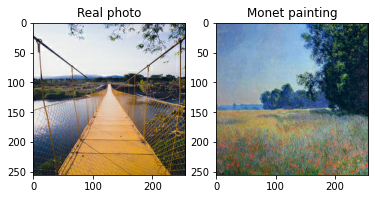

In [ ]:
example_monet , example_photo = next(iter(full_dataset))
# Visualizing the real photo
plt.subplot(121)
plt.title('Real photo')
plt.imshow(example_photo[2] * 0.5 + 0.5)

# Visualizing the Monet painting
plt.subplot(122)
plt.title('Monet painting')
plt.imshow(example_monet[2]* 0.5 + 0.5)

### Build the Generator

We'll be using a UNet architecture for our CycleGAN (the main idea of the implementation is to utilize successive contracting layers, which are immediately followed by the upsampling operators for achieving higher resolution outputs on the input images. The shape of the so formed architecture is in the form of a 'U' and hence the following name. The network built is a fully convolutional network). To build our generator, let's first define our `downsample` and `upsample` methods.

The `downsample`, as the name suggests, reduces the 2D dimensions, the width and height, of the image by the stride. The stride is the length of the step the filter takes. Since the stride is 2, the filter is applied to every other pixel, hence reducing the weight and height by 2.

We'll be using an **instance normalization** instead of batch normalization. As the instance normalization is not standard in the TensorFlow API, we'll use the layer from TensorFlow Add-ons.


Batch version normalizes all images across the batch and spatial locations; instance version normalizes each element of the batch independently, i.e., across spatial locations only. In other words, where batch norm computes one mean and std dev (thus making the distribution of the whole layer Gaussian), instance norm computes T of them, making each individual image distribution look Gaussian, but not jointly.

In [ ]:
OUTPUT_CHANNELS = 3

def downsample(filters, size, apply_instancenorm=True):
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    result = keras.Sequential()
    result.add(layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

    if apply_instancenorm:
        result.add(tfa.layers.InstanceNormalization(gamma_initializer=gamma_init))

    result.add(layers.LeakyReLU())

    return result

`Upsample` does the opposite of downsample and increases the dimensions of the of the image. `Conv2DTranspose` does basically the opposite of a `Conv2D` layer.

In [ ]:
def upsample(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    result = keras.Sequential()
    result.add(layers.Conv2DTranspose(filters, size, strides=2,
                                      padding='same',
                                      kernel_initializer=initializer,
                                      use_bias=False))

    result.add(tfa.layers.InstanceNormalization(gamma_initializer=gamma_init))

    if apply_dropout:
        result.add(layers.Dropout(0.5))

    result.add(layers.ReLU())

    return result

Let's build our generator!

The generator first downsamples the input image and then upsample while establishing long skip connections. Skip connections are a way to help bypass the vanishing gradient problem by concatenating the output of a layer to multiple layers instead of only one. Here we concatenate the output of the downsample layer to the upsample layer in a symmetrical fashion.

In [ ]:
def Generator():
    inputs = layers.Input(shape=[256,256,3])

    # bs = batch size
    down_stack = [
        downsample(64, 4, apply_instancenorm=False), # (bs, 128, 128, 64)
        downsample(128, 4), # (bs, 64, 64, 128)
        downsample(256, 4), # (bs, 32, 32, 256)
        downsample(512, 4), # (bs, 16, 16, 512)
        downsample(512, 4), # (bs, 8, 8, 512)
        downsample(512, 4), # (bs, 4, 4, 512)
        downsample(512, 4), # (bs, 2, 2, 512)
        downsample(512, 4), # (bs, 1, 1, 512)
    ]

    up_stack = [
        upsample(512, 4, apply_dropout=True), # (bs, 2, 2, 1024)
        upsample(512, 4, apply_dropout=True), # (bs, 4, 4, 1024)
        upsample(512, 4, apply_dropout=True), # (bs, 8, 8, 1024)
        upsample(512, 4), # (bs, 16, 16, 1024)
        upsample(256, 4), # (bs, 32, 32, 512)
        upsample(128, 4), # (bs, 64, 64, 256)
        upsample(64, 4), # (bs, 128, 128, 128)
    ]

    initializer = tf.random_normal_initializer(0., 0.02)
    last = layers.Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                  strides=2,
                                  padding='same',
                                  kernel_initializer=initializer,
                                  activation='tanh') # (bs, 256, 256, 3)

    x = inputs

    # Downsampling through the model
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)

    skips = reversed(skips[:-1])

    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = layers.Concatenate()([x, skip])

    x = last(x)

    return keras.Model(inputs=inputs, outputs=x)

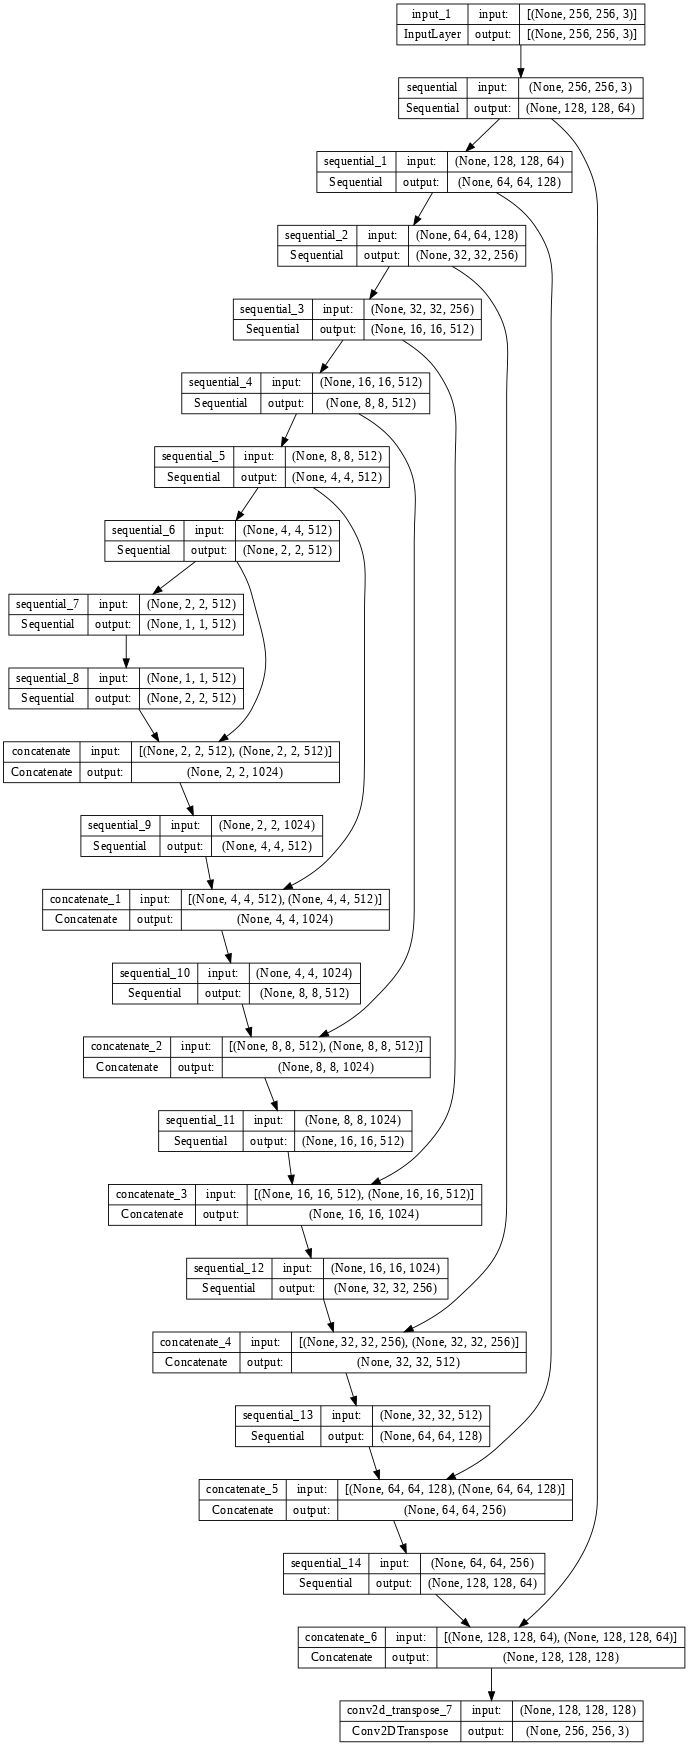

In [ ]:
# We can show the architecture of generator
generator_g = Generator()
tf.keras.utils.plot_model(generator_g, show_shapes=True, dpi=64)

### Build the discriminator

The discriminator takes in the input image and classifies it as real or fake (generated). Instead of outputing a single node, the discriminator outputs a smaller 2D image with higher pixel values indicating a real classification and lower values indicating a fake classification.

In [ ]:
def Discriminator():
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    inp = layers.Input(shape=[256, 256, 3], name='input_image')

    x = inp

    down1 = downsample(64, 4, False)(x) # (bs, 128, 128, 64)
    down2 = downsample(128, 4)(down1) # (bs, 64, 64, 128)
    down3 = downsample(256, 4)(down2) # (bs, 32, 32, 256)


# NOW HE ADD THIS ZERO PADDING TO PERFORM THEN A CONVOLUTIONAL LAYER WITH STRIDES 1 BUT WHYYYY ????
    zero_pad1 = layers.ZeroPadding2D()(down3) # (bs, 34, 34, 256) #This layer can add rows and columns of zeros
    conv = layers.Conv2D(512, 4, strides=1,
                         kernel_initializer=initializer,
                         use_bias=False)(zero_pad1) # (bs, 31, 31, 512)

    norm1 = tfa.layers.InstanceNormalization(gamma_initializer=gamma_init)(conv)

    leaky_relu = layers.LeakyReLU()(norm1)

    zero_pad2 = layers.ZeroPadding2D()(leaky_relu) # (bs, 33, 33, 512)

    last = layers.Conv2D(1, 4, strides=1,
                         kernel_initializer=initializer)(zero_pad2) # (bs, 30, 30, 1)

    return tf.keras.Model(inputs=inp, outputs=last)

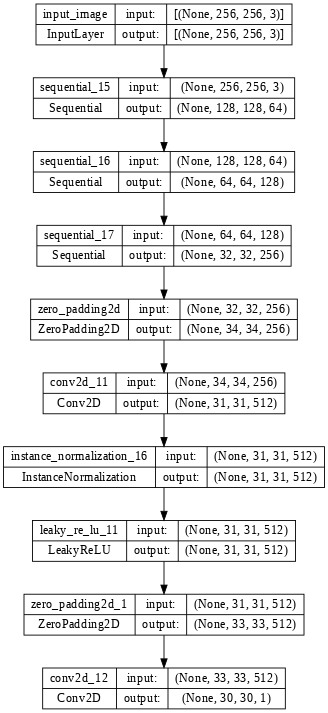

In [ ]:
# We can show the architecture
discriminator_y = Discriminator()
tf.keras.utils.plot_model(discriminator_y, show_shapes=True, dpi=64)

Distribution strategies were introduced as part of TF2 to help distribute training across multiple GPUs, multiple machines or TPUs with minimal code changes. \\
**Strategy.scope()** indica a Keras quale strategia utilizzare per distribuire la formazione. Serve per utilizzare i parametri definiti all'inizio del codice.

In [ ]:
with strategy.scope():
    monet_generator = Generator() # transforms photos to Monet-esque paintings
    photo_generator = Generator() # transforms Monet paintings to be more like photos

    monet_discriminator = Discriminator() # differentiates real Monet paintings and generated Monet paintings
    photo_discriminator = Discriminator() # differentiates real photos and generated photos

As we can see by the following cell, now we have created the model but it is not trained yet so we have no results by applying it to a real photo.

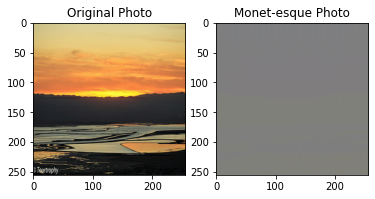

In [ ]:
to_monet = monet_generator(example_photo)

plt.subplot(1, 2, 1)
plt.title("Original Photo")
plt.imshow(example_photo[0] * 0.5 + 0.5)

plt.subplot(1, 2, 2)
plt.title("Monet-esque Photo")
plt.imshow(to_monet[0] * 0.5 + 0.5)
plt.show()

### Build the CycleGAN model


The CycleGAN is an extension of the GAN architecture that involves the simultaneous training of two generator models and two discriminator models. \\

The CycleGAN uses an additional extension to the architecture called cycle consistency. This is the idea that an image output by the first generator could be used as input to the second generator and the output of the second generator should match the original image. \\

We will subclass a **`tf.keras.Model`** so that we can run `fit()` later to train our model. During the training step, the model transforms a photo to a Monet painting and then back to a photo. The difference between the original photo and the twice-transformed photo is the cycle-consistency loss. We want the original photo and the twice-transformed photo to be similar to one another.

The losses are defined in the next section. The CycleGAN encourages cycle consistency by adding an additional loss to measure the difference between the generated output of the second generator and the original image, and the reverse. This acts as a regularization of the generator models, guiding the image generation process in the new domain toward image translation.

In [ ]:
class CycleGan(keras.Model):
    def __init__(
        self,
        monet_generator,
        photo_generator,
        monet_discriminator,
        photo_discriminator,
        lambda_cycle=10
        ):
        super(CycleGan, self).__init__()  #super() gives you access to methods in a superclass from the subclass that inherits from it.
        self.m_gen = monet_generator
        self.p_gen = photo_generator
        self.m_disc = monet_discriminator
        self.p_disc = photo_discriminator
        self.lambda_cycle = lambda_cycle
        
    def compile(
        self,
        m_gen_optimizer,
        p_gen_optimizer,
        m_disc_optimizer,
        p_disc_optimizer,
        gen_loss_fn,
        disc_loss_fn,
        cycle_loss_fn,
        identity_loss_fn
    ):
        super(CycleGan, self).compile()
        self.m_gen_optimizer = m_gen_optimizer
        self.p_gen_optimizer = p_gen_optimizer
        self.m_disc_optimizer = m_disc_optimizer
        self.p_disc_optimizer = p_disc_optimizer
        self.gen_loss_fn = gen_loss_fn
        self.disc_loss_fn = disc_loss_fn
        self.cycle_loss_fn = cycle_loss_fn
        self.identity_loss_fn = identity_loss_fn
        
    def train_step(self, batch_data):
        real_monet, real_photo = batch_data
        

        # tf.GradientTape record operations for automatic differentiation. It is used for calculating the gradient
        with tf.GradientTape(persistent=True) as tape: 
            # photo to monet back to photo
            fake_monet = self.m_gen(real_photo, training=True)
            cycled_photo = self.p_gen(fake_monet, training=True)

            # monet to photo back to monet
            fake_photo = self.p_gen(real_monet, training=True)
            cycled_monet = self.m_gen(fake_photo, training=True)

            # generating itself. Used for calculating the identity loss of the generator.
            same_monet = self.m_gen(real_monet, training=True)
            same_photo = self.p_gen(real_photo, training=True)

            # discriminator used to check, inputing real images
            disc_real_monet = self.m_disc(real_monet, training=True)
            disc_real_photo = self.p_disc(real_photo, training=True)

            # discriminator used to check, inputing fake images
            disc_fake_monet = self.m_disc(fake_monet, training=True)
            disc_fake_photo = self.p_disc(fake_photo, training=True)

            # evaluates generator loss
            monet_gen_loss = self.gen_loss_fn(disc_fake_monet)
            photo_gen_loss = self.gen_loss_fn(disc_fake_photo)

            # evaluates total cycle consistency loss
            total_cycle_loss = self.cycle_loss_fn(real_monet, cycled_monet, self.lambda_cycle) + self.cycle_loss_fn(real_photo, cycled_photo, self.lambda_cycle)

            # evaluates total generator loss
            total_monet_gen_loss = monet_gen_loss + total_cycle_loss + self.identity_loss_fn(real_monet, same_monet, self.lambda_cycle)
            total_photo_gen_loss = photo_gen_loss + total_cycle_loss + self.identity_loss_fn(real_photo, same_photo, self.lambda_cycle)

            # evaluates discriminator loss
            monet_disc_loss = self.disc_loss_fn(disc_real_monet, disc_fake_monet)
            photo_disc_loss = self.disc_loss_fn(disc_real_photo, disc_fake_photo)

        # Calculate the gradients for generator and discriminator. Il primo input è la funzione da differenziare, il secondo è la variabile
        monet_generator_gradients = tape.gradient(total_monet_gen_loss,
                                                  self.m_gen.trainable_variables)
        photo_generator_gradients = tape.gradient(total_photo_gen_loss,
                                                  self.p_gen.trainable_variables)

        monet_discriminator_gradients = tape.gradient(monet_disc_loss,
                                                      self.m_disc.trainable_variables)
        photo_discriminator_gradients = tape.gradient(photo_disc_loss,
                                                      self.p_disc.trainable_variables)

        # Apply the gradients to the optimizer
        self.m_gen_optimizer.apply_gradients(zip(monet_generator_gradients,
                                                 self.m_gen.trainable_variables))

        self.p_gen_optimizer.apply_gradients(zip(photo_generator_gradients,
                                                 self.p_gen.trainable_variables))

        self.m_disc_optimizer.apply_gradients(zip(monet_discriminator_gradients,
                                                  self.m_disc.trainable_variables))

        self.p_disc_optimizer.apply_gradients(zip(photo_discriminator_gradients,
                                                  self.p_disc.trainable_variables))
        
        return {
            "monet_gen_loss": total_monet_gen_loss,
            "photo_gen_loss": total_photo_gen_loss,
            "monet_disc_loss": monet_disc_loss,
            "photo_disc_loss": photo_disc_loss
        }

### Define loss functions

The discriminator loss function below compares real images to a matrix of 1s and fake images to a matrix of 0s. The perfect discriminator will output all 1s for real images and all 0s for fake images. The discriminator loss outputs the average of the real and generated loss.

In [ ]:
with strategy.scope():
    def discriminator_loss(real, generated):
      #prima vedo se il discriminatore ha predetto bene le immagini vere come originali (real_loss) 
      # e poi vedo se ha capito quali erano quelle finte (generated_loss) e faccio la media aritmetica

        real_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(real), real)
        # from_logits = True means that the model's prediction represents a logit, 
        # (i.e, value in [-inf, inf] when from_logits=True) while from_logits=False 
        # indicates a probability (i.e, value in [0., 1.]).

        generated_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.zeros_like(generated), generated)

        total_disc_loss = real_loss + generated_loss

        return total_disc_loss * 0.5

The generator wants to fool the discriminator into thinking the generated image is real. The perfect generator will have the discriminator output only 1s. Thus, it compares the generated image to a matrix of 1s to find the loss.

In [ ]:
with strategy.scope():
    def generator_loss(generated):

        return tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(generated), generated)

We want our original photo and the twice transformed photo to be similar to one another. Thus, we can calculate the cycle consistency loss be finding the average of their difference.

In [ ]:
with strategy.scope():
    def calc_cycle_loss(real_image, cycled_image, LAMBDA):
        loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))

        return LAMBDA * loss1

The identity loss compares the image with its generator (i.e. photo with photo generator). If given a photo as input, we want it to generate the same image as the image was originally a photo. The identity loss compares the input with the output of the generator.

In [ ]:
with strategy.scope():
    def identity_loss(real_image, same_image, LAMBDA):
        loss = tf.reduce_mean(tf.abs(real_image - same_image))
        return LAMBDA * 0.5 * loss

### Train the CycleGAN

Let's compile our model. Since we used `tf.keras.Model` to build our CycleGAN, we can just ude the `fit` function to train our model.

In [ ]:
with strategy.scope():
    monet_generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
    photo_generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

    monet_discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
    photo_discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [ ]:
with strategy.scope():
    cycle_gan_model = CycleGan(
        monet_generator, photo_generator, monet_discriminator, photo_discriminator
    )

    cycle_gan_model.compile(
        m_gen_optimizer = monet_generator_optimizer,
        p_gen_optimizer = photo_generator_optimizer,
        m_disc_optimizer = monet_discriminator_optimizer,
        p_disc_optimizer = photo_discriminator_optimizer,
        gen_loss_fn = generator_loss,
        disc_loss_fn = discriminator_loss,
        cycle_loss_fn = calc_cycle_loss,
        identity_loss_fn = identity_loss
    )

In [ ]:
cycle_gan_model.fit(
    tf.data.Dataset.zip((monet_ds, photo_ds)),
    epochs= 100
)

Epoch 1/100
75/75 [==============================] - 89s 774ms/step - monet_gen_loss: 7.3017 - photo_gen_loss: 7.5194 - monet_disc_loss: 0.6130 - photo_disc_loss: 0.6193
Epoch 2/100
75/75 [==============================] - 60s 780ms/step - monet_gen_loss: 4.8300 - photo_gen_loss: 4.9209 - monet_disc_loss: 0.5634 - photo_disc_loss: 0.5480
Epoch 3/100
75/75 [==============================] - 62s 805ms/step - monet_gen_loss: 4.1449 - photo_gen_loss: 4.3694 - monet_disc_loss: 0.6297 - photo_disc_loss: 0.4712
Epoch 4/100
75/75 [==============================] - 63s 810ms/step - monet_gen_loss: 3.8784 - photo_gen_loss: 4.4720 - monet_disc_loss: 0.6145 - photo_disc_loss: 0.3782
Epoch 5/100
75/75 [==============================] - 63s 810ms/step - monet_gen_loss: 3.9839 - photo_gen_loss: 4.2782 - monet_disc_loss: 0.5316 - photo_disc_loss: 0.5095
Epoch 6/100
75/75 [==============================] - 63s 809ms/step - monet_gen_loss: 4.2330 - photo_gen_loss: 4.2905 - monet_disc_loss: 0.4745 - phot

In [ ]:
# path = '/content/drive/MyDrive/monet_weights/my_weights'
# cycle_gan_model.save_weights(path)

In [ ]:
# cycle_gan_model.load_weights('/content/drive/MyDrive/monet_weights')

### Visualize our Monet-esque photos

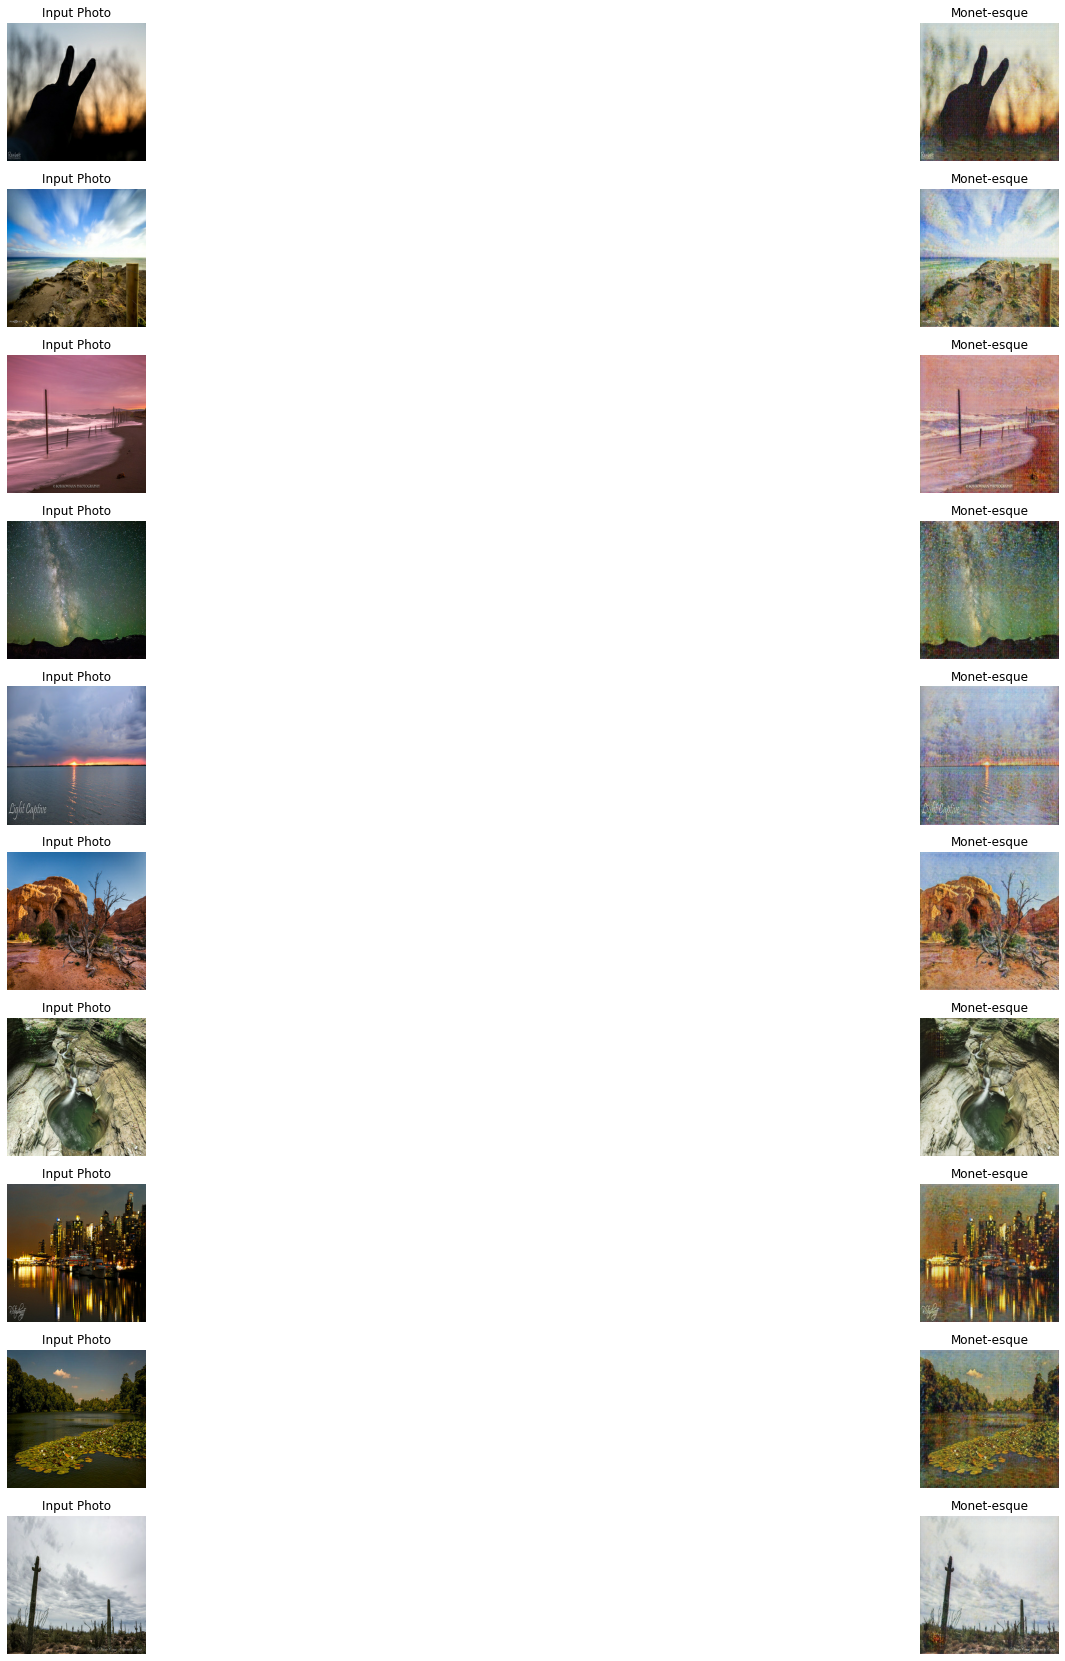

In [ ]:

_, ax = plt.subplots(10, 2, figsize=(30, 30))
# _, ax = plt.subplots(10, 3, figsize=(25, 25))
for i, img in enumerate(photo_ds.take(10)):
    prediction = monet_generator(img, training=False)[0].numpy()
    #cycle_real = photo_generator(prediction.reshape(1,256,256,3), training = False)[0].numpy()

    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    img = (img[0] * 127.5 + 127.5).numpy().astype(np.uint8)
    #cycle_real = (cycle_real * 127.5 + 127.5).astype(np.uint8)

    ax[i, 0].imshow(img)
    ax[i, 1].imshow(prediction)
    #ax[i, 2].imshow(cycle_real)
    ax[i, 0].set_title("Input Photo")
    ax[i, 1].set_title("Monet-esque")
    #ax[i, 2].set_tytle("Re-photo real")
    ax[i, 0].axis("off")
    ax[i, 1].axis("off")
    #ax[i, 2].axis("off")
plt.show()